In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tiktoken
import dataframe_image as dfi

# 1- For User queries

## Read Data

### Table 1 :  FT_SEARCH_TERMS

In [2]:
df = pd.read_parquet("../data-extraction/snowflakeTest/FT_SEARCH_TERMS.parquet")
en_df = df.loc[df["LANGUAGE"]=="en-US"]

### Table 2 : PERFORMANCE_REPORT_CUSTOM (Google)

In [3]:
df2 = pd.read_parquet("../data-extraction/snowflakeTest/PERFORMANCE_REPORT_CUSTOM.parquet")
df2.head()

,COUNTRY,DATE,QUERY
0,dnk,2020-03-30 17:00:00-07:00,talend sap
1,fra,2020-04-26 17:00:00-07:00,sap talend
2,fra,2020-04-05 17:00:00-07:00,tflowtoiterate talend
3,usa,2020-04-06 17:00:00-07:00,talend tftpfilelist
4,che,2020-03-30 17:00:00-07:00,talend java version


### Table 3 : SEARCH_QUERY_TERMS

In [4]:
df3 = pd.read_parquet("../data-extraction/snowflakeTest/SEARCH_QUERY_TERMS.parquet")
df3 = df3[["INPUT_VALUES_DROPDOWN_MODULE","INPUT_VALUES_SEARCH_QUERY"]]
df3 = df3.loc[df3["INPUT_VALUES_SEARCH_QUERY"] != '']
# max length of query
df3["INPUT_VALUES_SEARCH_QUERY"].apply(lambda x: len(x.split())).max()

161

calculate the cost & the number of tokens

In [5]:
# gpt-3.5-turbo model
def nb_cost_encodings_gpt_turbo(queries: list) -> None:
    
    L={}
    query_terms=[]
    num_tokens = []
    cost =[]
    for query in queries:
        encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
        num_tokens_query = len(encoding.encode(query))

        query_terms.append(query)
        num_tokens.append(num_tokens_query)
        cost.append((num_tokens_query*0.002)/1000)

    L["num_tokens"] = num_tokens
    L["cost"] = cost
    L["query_terms"] = query_terms
    return L

# text-embedding-ada-002 model
def nb_cost_encodings_ada(queries: list) -> None:
    
    L={}
    query_terms=[]
    num_tokens = []
    cost =[]
    for query in queries:
        encoding = tiktoken.encoding_for_model("text-embedding-ada-002")
        num_tokens_query = len(encoding.encode(query))

        query_terms.append(query)
        num_tokens.append(num_tokens_query)
        cost.append((num_tokens_query*0.0004)/1000)

    L["num_tokens"] = num_tokens
    L["cost"] = cost
    L["query_terms"] = query_terms
    return L

==> cost and number of tokens for the Help talend center Table:


In [7]:
df_gpturbo = pd.DataFrame.from_dict(nb_cost_encodings_gpt_turbo(list(en_df["QUERY_TERMS"].unique())))
df_ada = pd.DataFrame.from_dict(nb_cost_encodings_ada(list(en_df["QUERY_TERMS"].unique())))


In [9]:
df_gpturbo[['num_tokens']].quantile([0.90, 0.95, 0.99])

,num_tokens
0.90,9.00
0.95,12.00
0.99,22.57


In [11]:
# descriptive statistics
new = {"num_tokens":[9.0,12.0, 22.0]}
df_nouvelles_lignes = pd.DataFrame(new, index=['90%', '95%', '99%'])
index_derniere_ligne = df_gpturbo[['num_tokens']].describe().index[-1]
df_resultat = pd.concat([df_gpturbo[['num_tokens']].describe().loc[:index_derniere_ligne], df_nouvelles_lignes, df_gpturbo[['num_tokens']].describe().loc[index_derniere_ligne:]])

df_resultat = df_resultat.drop_duplicates(keep='last')
df_resultat


,num_tokens
count,35444.000000
mean,5.140165
std,9.960291
min,1.000000
25%,3.000000
50%,4.000000
75%,6.000000
90%,9.000000
95%,12.000000
99%,22.000000


we notice that the max token = 1145, this is why :

In [12]:
df_gpturbo.loc[df_gpturbo["num_tokens"]== 1145]

,num_tokens,cost,query_terms
32207,1145,0.00229,javax.net.ssl.sslhandshakeexception: pkix path...


==> cost and number of tokens for google Table:

In [13]:
df2_gpturbo = pd.DataFrame.from_dict(nb_cost_encodings_gpt_turbo(list(df2["QUERY"].unique())))
df2_ada = pd.DataFrame.from_dict(nb_cost_encodings_ada(list(df2["QUERY"].unique())))

In [14]:
df2_gpturbo[['num_tokens']].quantile([0.90, 0.95, 0.99])

,num_tokens
0.90,8.0
0.95,10.0
0.99,15.0


In [15]:
#descriptive statistics
new = {"num_tokens":[8.0,10.0, 15]}
df_nouvelles_lignes = pd.DataFrame(new, index=['90%', '95%', '99%'])
index_derniere_ligne = df2_gpturbo[['num_tokens']].describe().index[-1]
df_resultat = pd.concat([df2_gpturbo[['num_tokens']].describe().loc[:index_derniere_ligne], df_nouvelles_lignes, df2_gpturbo[['num_tokens']].describe().loc[index_derniere_ligne:]])

df_resultat = df_resultat.drop_duplicates(keep='last')
df_resultat

,num_tokens
count,11474.000000
mean,5.241764
std,3.022928
min,1.000000
25%,3.000000
50%,5.000000
75%,6.000000
90%,8.000000
95%,10.000000
99%,15.000000


In [16]:
df2_gpturbo.loc[df2_gpturbo["num_tokens"]== 88]

,num_tokens,cost,query_terms
7610,88,0.000176,usage: git remote add [<options>] <name> <url>...


==> cost and number of tokens for the IPC Table:

In [17]:
df3_gpturbo = pd.DataFrame.from_dict(nb_cost_encodings_gpt_turbo(list(df3["INPUT_VALUES_SEARCH_QUERY"].unique())))
df3_ada = pd.DataFrame.from_dict(nb_cost_encodings_ada(list(df3["INPUT_VALUES_SEARCH_QUERY"].unique())))


In [18]:
df3_gpturbo[['num_tokens']].quantile([0.90, 0.95, 0.99])

,num_tokens
0.90,9.0
0.95,15.0
0.99,42.0


In [19]:
#descriptive statistics

new = {"num_tokens":[9.0,15.0, 42]}
df_nouvelles_lignes = pd.DataFrame(new, index=['90%', '95%', '99%'])
index_derniere_ligne = df3_gpturbo[['num_tokens']].describe().index[-1]
df_resultat = pd.concat([df3_gpturbo[['num_tokens']].describe().loc[:index_derniere_ligne], df_nouvelles_lignes, df3_gpturbo[['num_tokens']].describe().loc[index_derniere_ligne:]])

df_resultat = df_resultat.drop_duplicates(keep='last')
df_resultat

,num_tokens
count,7343.000000
mean,5.160697
std,8.365578
min,1.000000
25%,2.000000
50%,3.000000
75%,5.000000
90%,9.000000
95%,15.000000
99%,42.000000


In [20]:
df3_gpturbo.loc[df3_gpturbo["num_tokens"]== 189]

,num_tokens,cost,query_terms
5979,189,0.000378,What is the longest possible search string in ...


Plot & visualize tokens counts of all tables for only gpt-3.5-turbo & text-davinci-003 models

Text(0.5, 1.0, 'IPC queries')

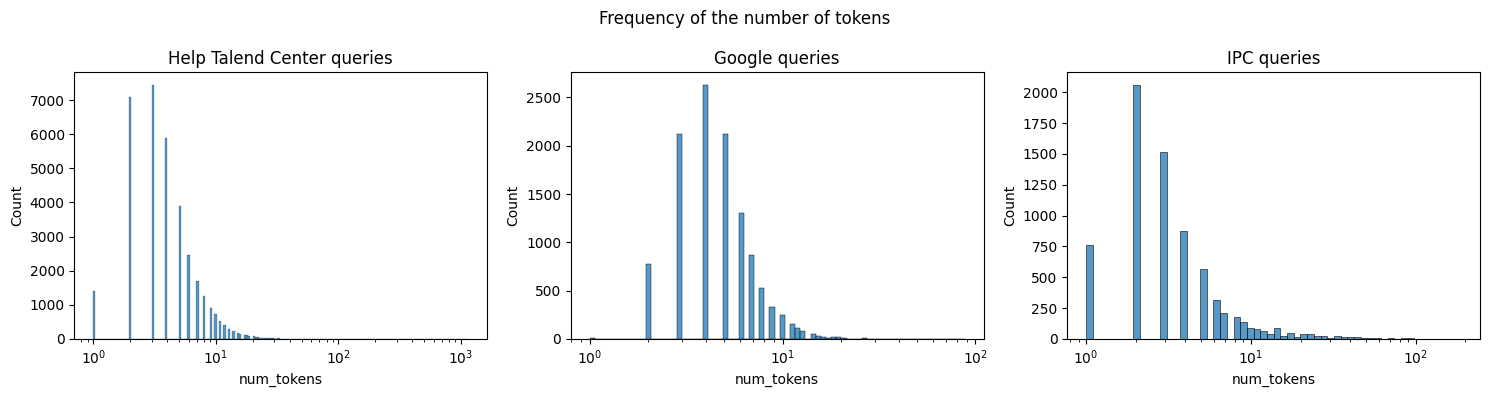

In [21]:
import seaborn as sns
fig, ax = plt.subplots(1, 3,
                        figsize =(15, 4),
                        tight_layout = True)
fig.suptitle('Frequency of the number of tokens')
sns.histplot(data=df_gpturbo, x="num_tokens", ax=ax[0], log_scale=True)
ax[0].set_title("Help Talend Center queries")
sns.histplot(data=df2_gpturbo, x="num_tokens",ax=ax[1],log_scale=True)
ax[1].set_title("Google queries")
sns.histplot(data=df3_gpturbo, x="num_tokens",discrete=False,ax=ax[2],log_scale=True)
ax[2].set_title("IPC queries")
# Show plot


Frequency of the number of tokens for 99% of queries

Text(0.5, 1.0, 'IPC queries')

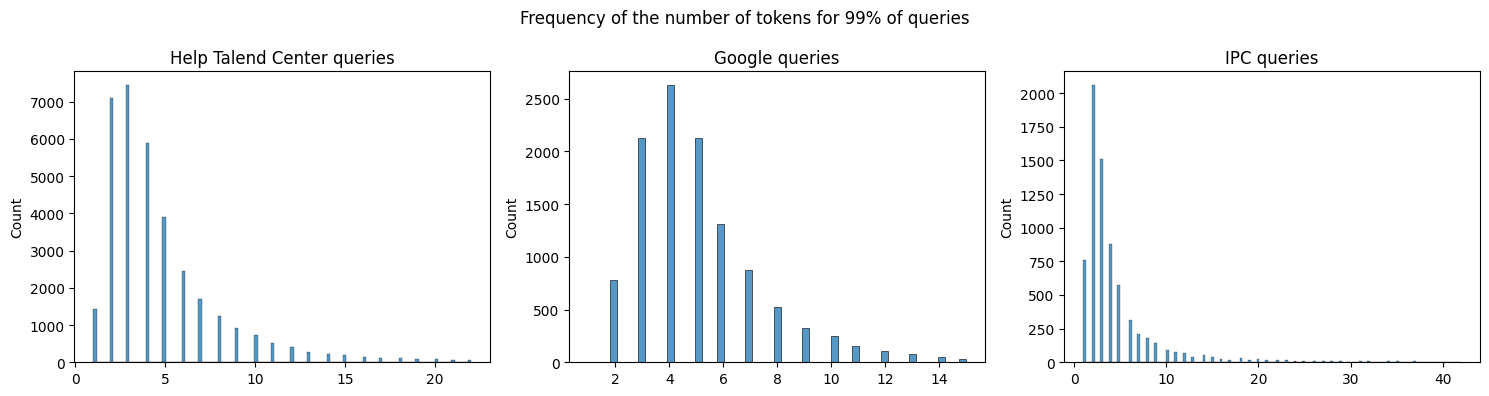

In [74]:
data_array = np.array(df_gpturbo['num_tokens'])
threshold = np.percentile(data_array, 99)
filtered_data = data_array[data_array <= threshold]

data_array2 = np.array(df2_gpturbo['num_tokens'])
threshold2 = np.percentile(data_array2, 99)
filtered_data2 = data_array2[data_array2 <= threshold2]

data_array3 = np.array(df3_gpturbo['num_tokens'])
threshold3 = np.percentile(data_array3, 99)
filtered_data3 = data_array3[data_array3 <= threshold3]

fig, ax = plt.subplots(1, 3,
                        figsize =(15, 4),
                        tight_layout = True)
fig.suptitle('Frequency of the number of tokens for 99% of queries')
sns.histplot(filtered_data, ax=ax[0], log_scale=False)
ax[0].set_title("Help Talend Center queries")
sns.histplot(filtered_data2,ax=ax[1],log_scale=False)
ax[1].set_title("Google queries")
sns.histplot(filtered_data3,discrete=False,ax=ax[2],log_scale=False)
ax[2].set_title("IPC queries")
# Show plot


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


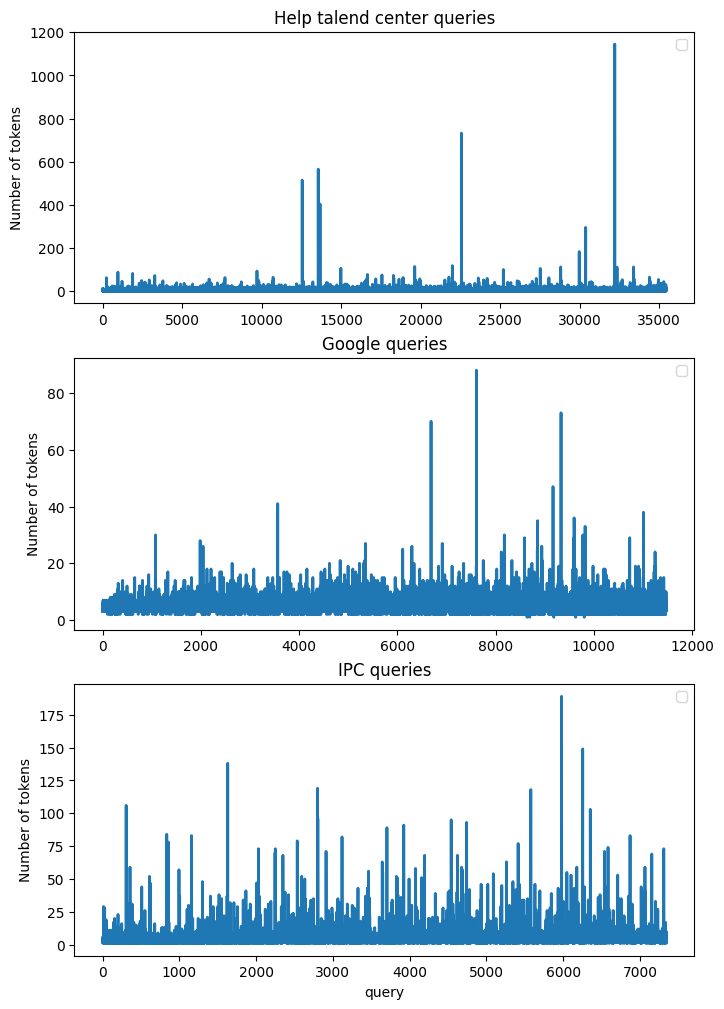

In [20]:
plt.figure(figsize=(8,12))

# help talend center table
plt.subplot(311)
plt.plot(df_gpturbo['num_tokens'], linewidth=2)
plt.title("Help talend center queries")
#plt.xlabel('query')
plt.ylabel('Number of tokens')
plt.legend()

#google table
plt.subplot(312)
plt.plot(df2_gpturbo['num_tokens'], linewidth=2)
plt.title("Google queries")
#plt.xlabel('query')
plt.ylabel('Number of tokens')
plt.legend()

#ipc table
plt.subplot(313)
plt.plot(df3_gpturbo['num_tokens'],linewidth=2)
plt.title("IPC queries")
plt.xlabel('query')
plt.ylabel('Number of tokens')
plt.legend()


plt.show()

plot & visualize tokens cost for each repository

In [129]:
dict = {"table" : ['help talend center',"Google",'IPC'],"text-embedding-ada-002 model":[df_ada['cost'].sum(),df2_ada['cost'].sum() ,df3_ada['cost'].sum()]}
df = pd.DataFrame.from_dict(dict)
df


,table,text-embedding-ada-002 model
0,help talend center,0.072875
1,Google,0.024058
2,IPC,0.015158


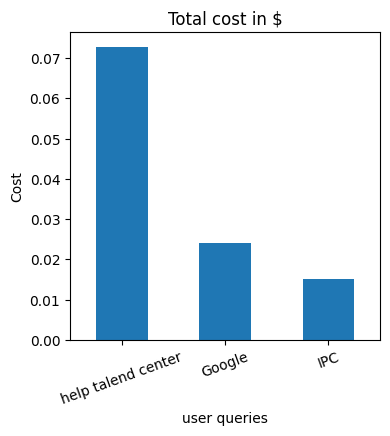

In [133]:
# Plotting the values
fig, ax = plt.subplots(figsize=(4,4))
df.set_index('table').plot(kind='bar',ax=ax, rot=20)

# Adding labels and title
plt.xlabel('user queries')
plt.ylabel('Cost')
plt.title('Total cost in $')
leg = plt.legend()

ax.get_legend().remove()
# Displaying the plot
plt.show()

# Documentation Content

#### Extract raw text from dita files

In [32]:
import os
import xml.etree.ElementTree as ET



def encode_repo(repository):
    
    # Set the directory containing the DITA files
    directory = "../LLM4Doc/github-content/"+str(repository) +"/en/"

    data ={}
    i = 0
    # Loop through all the folder in the directory
    for foldername in os.listdir(directory):
        dir = directory+str(foldername)
        # Loop through all the file in the directory
        for filename in os.listdir(dir):
            if filename.endswith(".dita"):
                filepath = os.path.join(dir, filename)
                
                # Parse the XML file
                tree = ET.parse(filepath)
                root = tree.getroot()
                
                # Extract the text content from all tags
                content = ""
                for element in root.iter():
                    if element.text:
                        content += element.text.strip() + " "
                    if element.tail:
                        content += element.tail.strip() + " "
                
                data[i]=[content]
                i+=1
    return data

In [33]:
docs_core = pd.DataFrame.from_dict(encode_repo("docs-core"), orient="index", columns = ['dita_file'])
docs_components = pd.DataFrame.from_dict(encode_repo("docs-components"), orient="index", columns = ['dita_file'])
docs_data_catalog = pd.DataFrame.from_dict(encode_repo("docs-data-catalog"), orient="index", columns = ['dita_file'])

print("docs-core: ",docs_core.shape[0], " dita files  |  and the longest text has ",docs_core["dita_file"].apply(lambda x: len(x.split())).max())
print("docs-components: ",docs_components.shape[0], " dita files  |  and the longest text has ",docs_components["dita_file"].apply(lambda x: len(x.split())).max())
print("docs-data-catalog: ",docs_data_catalog.shape[0], " dita files  |  and the longest text has ",docs_data_catalog["dita_file"].apply(lambda x: len(x.split())).max())


docs-core:  6521  dita files  |  and the longest text has  6891
docs-components:  6243  dita files  |  and the longest text has  5109
docs-data-catalog:  410  dita files  |  and the longest text has  1583


In [34]:
core_gpturbo = pd.DataFrame.from_dict(nb_cost_encodings_gpt_turbo(docs_core["dita_file"].to_list()))
core_ada = pd.DataFrame.from_dict(nb_cost_encodings_ada(docs_core["dita_file"].to_list()))

components_gpturbo = pd.DataFrame.from_dict(nb_cost_encodings_gpt_turbo(docs_components["dita_file"].to_list()))
components_ada = pd.DataFrame.from_dict(nb_cost_encodings_ada(docs_components["dita_file"].to_list()))

catalog_gpturbo = pd.DataFrame.from_dict(nb_cost_encodings_gpt_turbo(docs_data_catalog["dita_file"].to_list()))
catalog_ada = pd.DataFrame.from_dict(nb_cost_encodings_ada(docs_data_catalog["dita_file"].to_list()))

docs-core repository

In [35]:
core_gpturbo[['num_tokens']].quantile([0.90, 0.95, 0.99])

,num_tokens
0.90,625.0
0.95,910.0
0.99,1862.2


In [37]:
new = {"num_tokens":[625.0,910.0,1862]}
df_nouvelles_lignes = pd.DataFrame(new, index=['90%', '95%', '99%'])
index_derniere_ligne = core_gpturbo[['num_tokens']].describe().index[-1]
df_resultat = pd.concat([core_gpturbo[['num_tokens']].describe().loc[:index_derniere_ligne], df_nouvelles_lignes, core_gpturbo[['num_tokens']].describe().loc[index_derniere_ligne:]])

df_resultat = df_resultat.drop_duplicates(keep='last')
df_resultat

,num_tokens
count,6521.000000
mean,297.542095
std,482.985587
min,1.000000
25%,87.000000
50%,184.000000
75%,357.000000
90%,625.000000
95%,910.000000
99%,1862.000000


In [38]:
df_styled = df_resultat.style.background_gradient()
dfi.export(df_styled,"mytable4.png")

docs-components repository

In [39]:
components_gpturbo[['num_tokens']].quantile([0.90, 0.95, 0.99])

,num_tokens
0.90,546.0
0.95,773.9
0.99,1693.9


In [40]:
new = {"num_tokens":[546.0,773, 1693]}
df_nouvelles_lignes = pd.DataFrame(new, index=['90%', '95%','99%'])
index_derniere_ligne = components_gpturbo[['num_tokens']].describe().index[-1]
df_resultat = pd.concat([components_gpturbo[['num_tokens']].describe().loc[:index_derniere_ligne], df_nouvelles_lignes, components_gpturbo[['num_tokens']].describe().loc[index_derniere_ligne:]])

df_resultat = df_resultat.drop_duplicates(keep='last')
df_resultat

,num_tokens
count,6243.000000
mean,238.016819
std,358.920852
min,1.000000
25%,51.000000
50%,126.000000
75%,293.500000
90%,546.000000
95%,773.000000
99%,1693.000000


In [41]:
df_styled = df_resultat.style.background_gradient()
dfi.export(df_styled,"mytable5.png")

docs-data-catalog repository

In [43]:

catalog_gpturbo[['num_tokens']].quantile([0.90, 0.95, 0.99])


,num_tokens
0.90,560.30
0.95,809.10
0.99,1843.29


In [44]:
new = {"num_tokens":[560.0,809.0, 1843]}
df_nouvelles_lignes = pd.DataFrame(new, index=['90%', '95%', '99%'])
index_derniere_ligne = catalog_gpturbo[['num_tokens']].describe().index[-1]
df_resultat = pd.concat([catalog_gpturbo[['num_tokens']].describe().loc[:index_derniere_ligne], df_nouvelles_lignes, catalog_gpturbo[['num_tokens']].describe().loc[index_derniere_ligne:]])

df_resultat = df_resultat.drop_duplicates(keep='last')
df_resultat

,num_tokens
count,410.000000
mean,249.121951
std,349.348776
min,5.000000
25%,67.000000
50%,124.000000
75%,283.250000
90%,560.000000
95%,809.000000
99%,1843.000000


In [45]:
df_styled = df_resultat.style.background_gradient()
dfi.export(df_styled,"mytable6.png")

plot number of tokens for each repository

Text(0.5, 1.0, 'Docs-data-catalog dita-files')

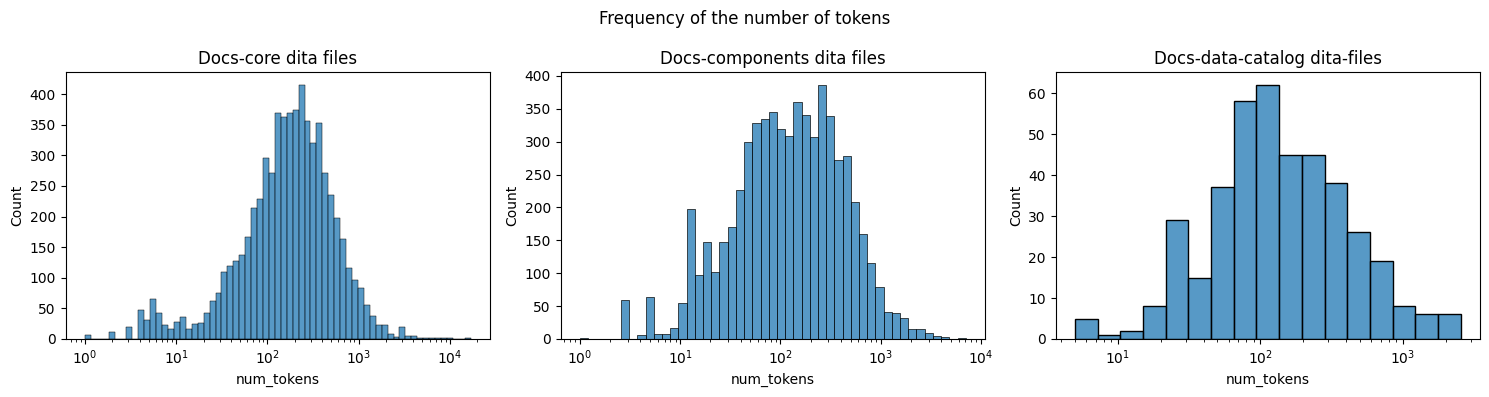

In [46]:
import seaborn as sns
fig, ax = plt.subplots(1, 3,
                        figsize =(15, 4),
                        tight_layout = True)
fig.suptitle('Frequency of the number of tokens')
sns.histplot(data=core_gpturbo, x="num_tokens", ax=ax[0], log_scale=True)
ax[0].set_title("Docs-core dita files")
sns.histplot(data=components_gpturbo, x="num_tokens",ax=ax[1],log_scale=True)
ax[1].set_title("Docs-components dita files")
sns.histplot(data=catalog_gpturbo, x="num_tokens",discrete=False,ax=ax[2],log_scale=True)
ax[2].set_title("Docs-data-catalog dita-files")
# Show plot


Frequency of the number of tokens for 99% of files

Text(0.5, 1.0, 'Docs-data-catalog dita-files')

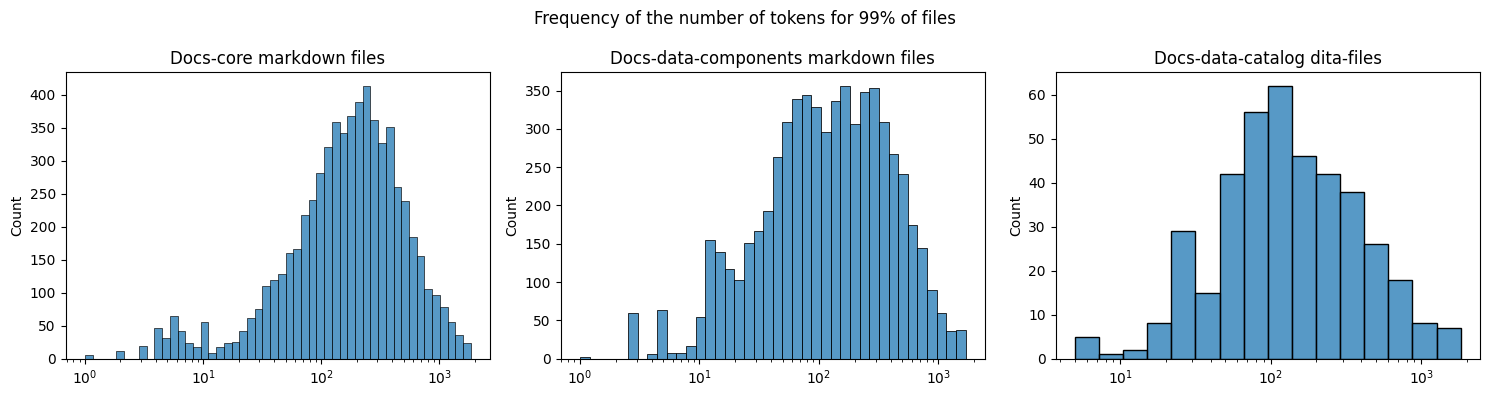

In [72]:
data_array = np.array(core_gpturbo['num_tokens'])
threshold = np.percentile(data_array, 99)
filtered_data = data_array[data_array <= threshold]

data_array2 = np.array(components_gpturbo['num_tokens'])
threshold2 = np.percentile(data_array2, 99)
filtered_data2 = data_array2[data_array2 <= threshold2]

data_array3 = np.array(catalog_gpturbo['num_tokens'])
threshold3 = np.percentile(data_array3, 99)
filtered_data3 = data_array3[data_array3 <= threshold3]

fig, ax = plt.subplots(1, 3,
                        figsize =(15, 4),
                        tight_layout = True)
fig.suptitle('Frequency of the number of tokens for 99% of files')
sns.histplot(filtered_data, ax=ax[0], log_scale=True)
ax[0].set_title("Docs-core markdown files")
sns.histplot(filtered_data2,ax=ax[1],log_scale=True)
ax[1].set_title("Docs-data-components markdown files")
sns.histplot(filtered_data3,discrete=False,ax=ax[2],log_scale=True)
ax[2].set_title("Docs-data-catalog dita-files")
# Show plot


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


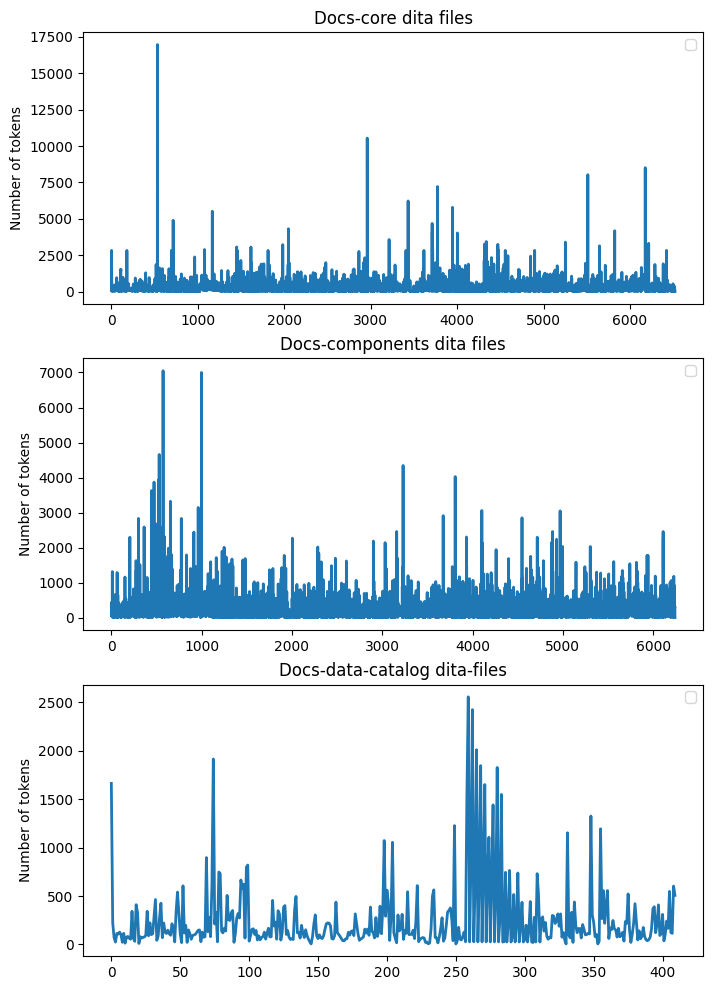

In [243]:
plt.figure(figsize=(8,12))

# Docs-core repository
plt.subplot(311)
plt.plot(core_gpturbo['num_tokens'],linewidth=2)
plt.title("Docs-core dita files")
#plt.xlabel('query')
plt.ylabel('Number of tokens')
plt.legend()

# Docs-components repository
plt.subplot(312)
plt.plot(components_gpturbo['num_tokens'],linewidth=2)
plt.title("Docs-components dita files")
#plt.xlabel('query')
plt.ylabel('Number of tokens')
plt.legend()

# Docs-data-catalog repository
plt.subplot(313)
plt.plot(catalog_gpturbo['num_tokens'], linewidth=2)
plt.title("Docs-data-catalog dita-files")

plt.ylabel('Number of tokens')
plt.legend()


plt.show()

plot & visualize tokens cost for each repository

In [35]:
dict = {"repository" : ['Docs-core',"Docs-components",'Docs-data-catalog'], "gpt-3.5-turbo model": [core_gpturbo['cost'].sum(),
                                                                                                    components_gpturbo['cost'].sum(),catalog_gpturbo['cost'].sum()],
        "text-embedding-ada-002 model":[core_ada['cost'].sum(),components_ada['cost'].sum(),catalog_ada['cost'].sum()]}

df = pd.DataFrame.from_dict(dict)
df


,repository,gpt-3.5-turbo model,text-embedding-ada-002 model
0,Docs-core,3.880544,0.776109
1,Docs-components,2.971878,0.594376
2,Docs-data-catalog,0.204280,0.040856


Cost estimation of each repository:

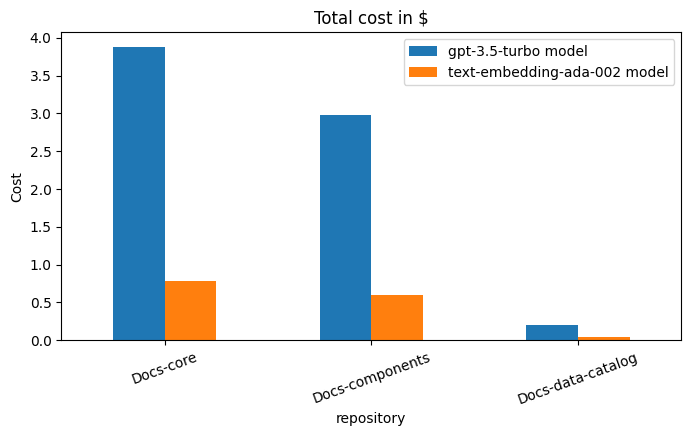

In [36]:
# Plotting the values
fig, ax = plt.subplots(figsize=(8,4))
df.set_index('repository').plot(kind='bar',ax=ax, rot=20)

# Adding labels and title
plt.xlabel('repository')
plt.ylabel('Cost')

plt.title('Total cost in $')

# Displaying the plot
plt.show()

### Markdown Content 

In [55]:
import re
import os
import markdown
from bs4 import BeautifulSoup

def read_markdown_files(root_folder):
    markdown_files = []
    
    data ={}
    i = 0

    # Recursively traverse through the root folder
    for foldername, _, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.endswith(".md"):  # Only consider Markdown files
                file_path = os.path.join(foldername, filename)
                markdown_files.append(file_path)
    
    # Read and process each Markdown file
    for file_path in markdown_files:
        with open(file_path, "r", encoding="utf-8") as file:
            markdown_content = file.read()
            html_content = markdown.markdown(markdown_content)
            soup = BeautifulSoup(html_content, 'html.parser')
            text = soup.get_text()

            data[i]=[text]
            i+=1
    return data


In [59]:
data_core = read_markdown_files("C:/Users/ehilmi/Desktop/LLM4Doc/github-content/docs-core/out_markdown")
data_catalog = read_markdown_files("C:/Users/ehilmi/Desktop/LLM4Doc/github-content/docs-data-catalog/out_markdown")
data_components = read_markdown_files("C:/Users/ehilmi/Desktop/LLM4Doc/github-content/docs-components/out")

df_data_core = pd.DataFrame.from_dict(data_core, orient="index", columns = ['markdown_file'])
df_data_catalog = pd.DataFrame.from_dict(data_catalog, orient="index", columns = ['markdown_file'])
df_data_components = pd.DataFrame.from_dict(data_components, orient="index", columns = ['markdown_file'])

In [60]:
data_core_gpturbo = pd.DataFrame.from_dict(nb_cost_encodings_gpt_turbo(df_data_core["markdown_file"].to_list()))
data_core_ada = pd.DataFrame.from_dict(nb_cost_encodings_ada(df_data_core["markdown_file"].to_list()))

data_components_gpturbo = pd.DataFrame.from_dict(nb_cost_encodings_gpt_turbo(df_data_components["markdown_file"].to_list()))
data_components_ada = pd.DataFrame.from_dict(nb_cost_encodings_ada(df_data_components["markdown_file"].to_list()))

data_catalog_gpturbo = pd.DataFrame.from_dict(nb_cost_encodings_gpt_turbo(df_data_catalog["markdown_file"].to_list()))
data_catalog_ada = pd.DataFrame.from_dict(nb_cost_encodings_ada(df_data_catalog["markdown_file"].to_list()))

data-core

In [61]:
data_core_gpturbo.quantile([0.90,0.95,0.99])

C:\Users\ehilmi\AppData\Local\Temp\ipykernel_20648\693139707.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_core_gpturbo.quantile([0.90,0.95,0.99])


,num_tokens,cost
0.90,635.60,0.001271
0.95,907.30,0.001815
0.99,1645.06,0.003290


In [62]:
new = {"num_tokens":[635.0, 907.0,1645]}
df_nouvelles_lignes = pd.DataFrame(new, index=['90%', '95%','99%'])
index_derniere_ligne = data_core_gpturbo[['num_tokens']].describe().index[-1]
df_resultat = pd.concat([data_core_gpturbo[['num_tokens']].describe().loc[:index_derniere_ligne], df_nouvelles_lignes, data_core_gpturbo[['num_tokens']].describe().loc[index_derniere_ligne:]])

df_resultat = df_resultat.drop_duplicates(keep='last')
df_styled = df_resultat.style.background_gradient()
dfi.export(df_styled,"mytable111.png")
df_resultat

,num_tokens
count,5895.000000
mean,327.237829
std,459.033774
min,20.000000
25%,132.000000
50%,223.000000
75%,381.000000
90%,635.000000
95%,907.000000
99%,1645.000000


data-catalog

In [63]:
data_catalog_gpturbo.quantile([0.90,0.95, 0.99])

C:\Users\ehilmi\AppData\Local\Temp\ipykernel_20648\1224904300.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_catalog_gpturbo.quantile([0.90,0.95, 0.99])


,num_tokens,cost
0.90,588.20,0.001176
0.95,828.10,0.001656
0.99,1789.66,0.003579


In [64]:
new = {"num_tokens":[588.0, 828.0,1789]}
df_nouvelles_lignes = pd.DataFrame(new, index=['90%', '95%','99%'])
index_derniere_ligne = data_catalog_gpturbo[['num_tokens']].describe().index[-1]
df_resultat = pd.concat([data_catalog_gpturbo[['num_tokens']].describe().loc[:index_derniere_ligne], df_nouvelles_lignes, data_catalog_gpturbo[['num_tokens']].describe().loc[index_derniere_ligne:]])

df_resultat = df_resultat.drop_duplicates(keep='last')
df_styled = df_resultat.style.background_gradient()
dfi.export(df_styled,"mytable222.png")
df_resultat

,num_tokens
count,404.000000
mean,272.403465
std,334.389467
min,5.000000
25%,89.750000
50%,154.500000
75%,312.500000
90%,588.000000
95%,828.000000
99%,1789.000000


In [65]:
data_components_gpturbo.quantile([0.90,0.95,0.99])

C:\Users\ehilmi\AppData\Local\Temp\ipykernel_20648\1037535064.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_components_gpturbo.quantile([0.90,0.95,0.99])


,num_tokens,cost
0.90,1266.10,0.002532
0.95,1672.15,0.003344
0.99,2777.73,0.005555


data-components

In [66]:
new = {"num_tokens":[1266.0, 1672.0,2777]}
df_nouvelles_lignes = pd.DataFrame(new, index=['90%', '95%','99%'])
index_derniere_ligne = data_components_gpturbo[['num_tokens']].describe().index[-1]
df_resultat = pd.concat([data_components_gpturbo[['num_tokens']].describe().loc[:index_derniere_ligne], df_nouvelles_lignes, data_components_gpturbo[['num_tokens']].describe().loc[index_derniere_ligne:]])

df_resultat = df_resultat.drop_duplicates(keep='last')
df_styled = df_resultat.style.background_gradient()
dfi.export(df_styled,"mytable333.png")
df_resultat

,num_tokens
count,5480.000000
mean,456.052555
std,608.964497
min,18.000000
25%,110.000000
50%,212.500000
75%,514.000000
90%,1266.000000
95%,1672.000000
99%,2777.000000


In [67]:
data_components_gpturbo['num_tokens'].sort_values(ascending=False)[:10]

732     6522
2688    6448
2677    6263
2681    6259
2683    6069
1801    5862
2662    4966
4871    4854
4960    4844
4957    4782
Name: num_tokens, dtype: int64

plot & visualize number of tokens for each repository in markdown format

Text(0.5, 1.0, 'Docs-data-catalog dita-files')

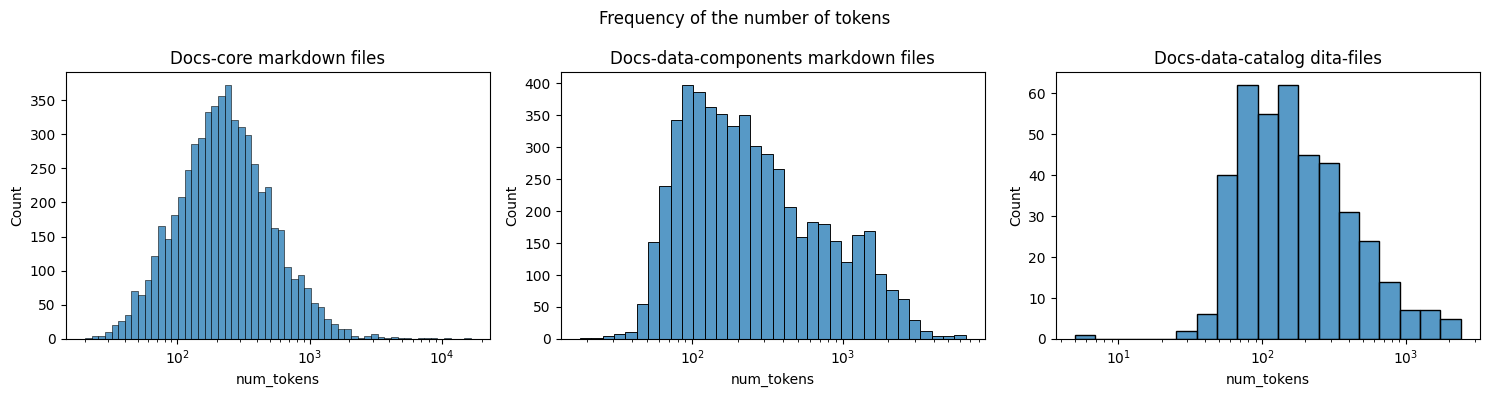

In [164]:
import seaborn as sns
fig, ax = plt.subplots(1, 3,
                        figsize =(15, 4),
                        tight_layout = True)
fig.suptitle('Frequency of the number of tokens')
sns.histplot(data=data_core_gpturbo, x="num_tokens", ax=ax[0], log_scale=True)
ax[0].set_title("Docs-core markdown files")
sns.histplot(data=data_components_gpturbo, x="num_tokens",ax=ax[1],log_scale=True)
ax[1].set_title("Docs-data-components markdown files")
sns.histplot(data=data_catalog_gpturbo, x="num_tokens",discrete=False,ax=ax[2],log_scale=True)
ax[2].set_title("Docs-data-catalog dita-files")
# Show plot

Frequency of the number of tokens for 99% of files

Text(0.5, 1.0, 'Docs-data-catalog dita-files')

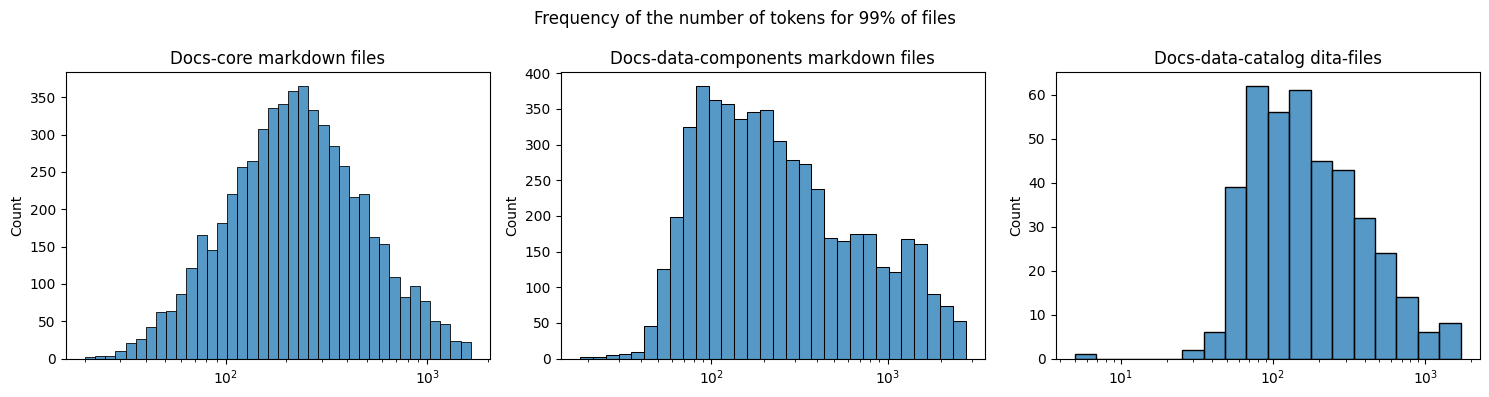

In [75]:
data_array = np.array(data_core_gpturbo['num_tokens'])
threshold = np.percentile(data_array, 99)
filtered_data = data_array[data_array <= threshold]

data_array2 = np.array(data_components_gpturbo['num_tokens'])
threshold2 = np.percentile(data_array2, 99)
filtered_data2 = data_array2[data_array2 <= threshold2]

data_array3 = np.array(data_catalog_gpturbo['num_tokens'])
threshold3 = np.percentile(data_array3, 99)
filtered_data3 = data_array3[data_array3 <= threshold3]

fig, ax = plt.subplots(1, 3,
                        figsize =(15, 4),
                        tight_layout = True)
fig.suptitle("Frequency of the number of tokens for 99% of files")
sns.histplot(filtered_data, ax=ax[0], log_scale=True)
ax[0].set_title("Docs-core markdown files")
sns.histplot(filtered_data2,ax=ax[1],log_scale=True)
ax[1].set_title("Docs-data-components markdown files")
sns.histplot(filtered_data3,discrete=False,ax=ax[2],log_scale=True)
ax[2].set_title("Docs-data-catalog dita-files")
# Show plot


In [165]:
dict = {"repository" : ['Docs-core',"Docs-components",'Docs-data-catalog'], "gpt-3.5-turbo model": [data_core_gpturbo['cost'].sum(),
                                                                                                    data_components_gpturbo['cost'].sum(), data_catalog_gpturbo['cost'].sum()],
        "text-embedding-ada-002 model":[data_core_ada['cost'].sum(),data_components_ada['cost'].sum(),data_catalog_ada['cost'].sum()]}

df = pd.DataFrame.from_dict(dict)
df

,repository,gpt-3.5-turbo model,text-embedding-ada-002 model
0,Docs-core,3.858134,0.771627
1,Docs-components,4.998336,0.999667
2,Docs-data-catalog,0.220102,0.044020


Cost estimation of each repository:

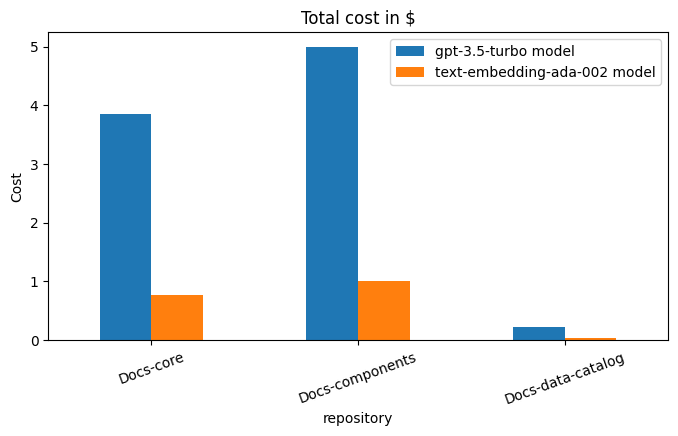

In [167]:
# Plotting the values
fig, ax = plt.subplots(figsize=(8,4))
df.set_index('repository').plot(kind='bar',ax=ax, rot=20)

# Adding labels and title
plt.xlabel('repository')
plt.ylabel('Cost')
plt.title('Total cost in $')

# Displaying the plot
plt.show()